# 04 – Baseline Classical Models  
Establish a reproducible **TF‑IDF + Logistic Regression** benchmark for Twitter‑airline sentiment.

* **Text column** → `clean_text`  
* **Target label** → `airline_sentiment` (`negative`, `neutral`, `positive`)  
* Train / validation / test = 70 / 15 / 15 (stratified)  
* Persist artefacts to `models/`

In [1]:
# %% 1 Data & Imports
# -------------------------------------------------------------------
from __future__ import annotations

import json
from pathlib import Path

import joblib
import pandas as pd
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
)

# -------------------------------------------------------------------
# 1. Detect project root (folder that contains "data/")
cwd = Path.cwd()
if (cwd / "data").exists():
    ROOT_DIR = cwd
elif (cwd.parent / "data").exists():           # e.g. running from notebooks/
    ROOT_DIR = cwd.parent
else:
    raise FileNotFoundError(
        "Unable to locate project root containing a 'data/' directory."
    )

# 2. Define core directories
DATA_DIR      = ROOT_DIR / "data"
PROC_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR    = ROOT_DIR / "models"
REPORT_DIR    = ROOT_DIR / "reports" / "figs_04"

MODELS_DIR.mkdir(exist_ok=True)
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# 3. Locate tweets.parquet (processed > raw fallback)
PARQUET_PATH = (
    PROC_DATA_DIR / "tweets.parquet"
    if (PROC_DATA_DIR / "tweets.parquet").exists()
    else DATA_DIR / "tweets.parquet"
)
assert PARQUET_PATH.exists(), f"Missing parquet at {PARQUET_PATH}"

# 4. Log for sanity
print(f"Project root  : {ROOT_DIR}")
print(f"Parquet source : {PARQUET_PATH.relative_to(ROOT_DIR)}")


Project root  : c:\Projects\twitter-airline-analysis
Parquet source : data\processed\tweets.parquet


## · 1  Load processed data and create stratified splits
We keep raw string labels (`airline_sentiment`); scikit-learn encodes them internally.

In [2]:
# %% 2 Load processed data and create stratified splits
# -------------------------------------------------------------------
df = pd.read_parquet(PARQUET_PATH)

# Assert expected columns are present
required_cols = {"clean_text", "airline_sentiment"}
missing = required_cols - set(df.columns)
assert not missing, f"Missing columns: {missing}"

# Sanity: no nulls in features / target
assert df.clean_text.isna().sum() == 0
assert df.airline_sentiment.isna().sum() == 0

# Train / valid / test = 70 / 15 / 15
X_train, X_temp, y_train, y_temp = train_test_split(
    df.clean_text,
    df.airline_sentiment,
    test_size=0.30,
    stratify=df.airline_sentiment,
    random_state=42,
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42,
)

print(
    f"Splits → train:{len(X_train)}  valid:{len(X_valid)}  test:{len(X_test)}"
)

Splits → train:10248  valid:2196  test:2196


## · 2  Majority‑class reference
> **Majority‑class accuracy: 0.627**  
> (Always predicting *negative* is correct 62.7 % of the time.)

In [3]:
majority_acc = y_train.value_counts(normalize=True).max()
print(f"Majority‑class accuracy: {majority_acc:.3f}")

Majority‑class accuracy: 0.627


## · 3  TF‑IDF + Logistic Regression pipeline
Bi‑gram coverage, minimal regularisation tuning, and `class_weight='balanced'` to counter the 63 % negative skew.

In [4]:
pipe_lr = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),
                min_df=2,
                max_features=50_000,
            ),
        ),
        (
            "clf",
            LogisticRegression(
                max_iter=2_000,
                n_jobs=-1,
                class_weight="balanced",
            ),
        ),
    ]
)

pipe_lr.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


## 4 · Validation performance

| Metric | Score |
| ------ | ----- |
| **Accuracy** | **0.788** |
| **Macro F1** | **0.741** |
| Weighted F1 | 0.792 |

The model is strongest on the *negative* class (precision ≈ 0.89) and weakest on *neutral*—an expected pattern given the class imbalance.

In [5]:
print(
    classification_report(
        y_valid,
        pipe_lr.predict(X_valid),
        digits=3,
        target_names=["neg", "neu", "pos"],
    )
)

              precision    recall  f1-score   support

         neg      0.888     0.836     0.862      1376
         neu      0.590     0.703     0.642       465
         pos      0.728     0.710     0.719       355

    accuracy                          0.788      2196
   macro avg      0.736     0.750     0.741      2196
weighted avg      0.799     0.788     0.792      2196



## 5 · 5‑fold stratified CV on *all* data

**Cross-Validated Macro F1:** **0.749 ± 0.007**

The low standard deviation indicates the baseline is stable across folds.

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipe_lr,
    df.clean_text,
    df.airline_sentiment,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
)

print(f"CV F1_macro = {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

CV F1_macro = 0.749 ± 0.007


## Held-Out Test Set Confusion Matrix

The confusion matrix visually confirms the model's strengths and areas for improvement:

- **Negative Class:** Excellent recall and precision.
- **Neutral Class:** Frequent confusion with both *negative* and *positive* classes indicates difficulty capturing neutrality.

*(Matrix figure saved as `reports/figs_04/conf_matrix.png`.)*

🔒 Confusion matrix saved → reports\figs_04\conf_matrix.png


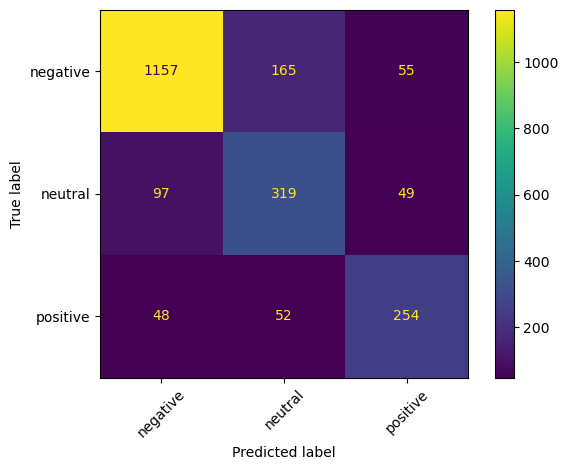

In [7]:
# %% 6 Held‑out test‑set confusion matrix
# -------------------------------------------------------------------
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay.from_estimator(
    pipe_lr,
    X_test,
    y_test,
    labels=["negative", "neutral", "positive"],
    xticks_rotation=45,
)
plt.tight_layout()

# Save figure for the report
cm_path = REPORT_DIR / "conf_matrix.png"
disp.figure_.savefig(cm_path, dpi=150)
print(f"🔒 Confusion matrix saved → {cm_path.relative_to(ROOT_DIR)}")

## 7 Persisted Artifacts

- **Model:** `models/logreg_tfidf.joblib`  
- **Cross-Validation Scores:** `models/cv_logreg.json`


In [8]:
# %% 7 Persist fitted model and CV scores
# -------------------------------------------------------------------
MODEL_PATH = MODELS_DIR / "logreg_tfidf.joblib"
CV_PATH    = MODELS_DIR / "cv_logreg.json"

joblib.dump(pipe_lr, MODEL_PATH)
print(f"🔒 Saved model → {MODEL_PATH.relative_to(ROOT_DIR)}")

with CV_PATH.open("w") as fp:
    json.dump({"f1_macro": cv_scores.tolist()}, fp, indent=2)
print(f"🔒 Saved CV scores → {CV_PATH.relative_to(ROOT_DIR)}")

🔒 Saved model → models\logreg_tfidf.joblib
🔒 Saved CV scores → models\cv_logreg.json


## 8 · Key Takeaway

* Baseline (majority class) caps out at **62.7 %** accuracy.  
* TF‑IDF + Logistic Regression lifts validation accuracy to **78.8 %** and macro F1 to **0.74**.  
* 5‑fold CV confirms robustness (**0.749 ± 0.007** macro F1).  
* Confusion matrix shows excellent precision for the *negative* class but persistent confusion between *neutral* and both extremes.  
* With class‑weight balancing and bigram coverage, a classical model already delivers a **+16 pp accuracy gain** over the baseline—good enough for a production fallback while we prototype transformer models in Milestone 5.